In [20]:
using PyPlot
using JuLIP
using JuLIP.ASE, JuLIP.Potentials, JuLIP.Constraints 
import ForwardDiff
reload("MaterialsScienceTools")

In [21]:
"a fully equilibrated SW potential"
function sw_eq()
    T(σ, at) = trace(stress(StillingerWeber(σ=σ), at))
    at = JuLIP.ASE.bulk("Si", pbc=true)
    r0 = 2.09474
    r1 = r0 - 0.1 
    s0, s1 = T(r0, at), T(r1, at)
    while (abs(s1) > 1e-8) && abs(r0 - r1) > 1e-8
        rnew = (r0 * s1 - r1 * s0) / (s1 - s0)
        r0, r1 = r1, rnew
        s0, s1 = s1, T(rnew, at)
    end
#     @show r1
    return StillingerWeber(σ=r1)
end 

# # quick test code to confirm that sw_eq() really produces a stress free state with no internal forces
# V = sw_eq()
# at = JuLIP.ASE.bulk("Si", cubic=true, pbc=true)
# @show vecnorm(stress(V, at), Inf), maximum(norm.(forces(V, at)))


sw_eq

In [22]:
reload("MaterialsScienceTools")

function si_plane(R)
    @assert isodd(R)
    atu, b, xcore, a = MaterialsScienceTools.Dislocations_Silicon_hard_110.fcc_edge_plane("Si")
    xcore = [0.0, 0.625 * a, 0.0]
    at = atu * (R, R, 1)
    set_pbc!(at, (false, false, true))
    b = b[1] 
    X = positions(at) |> mat 
    X = vecs(X)
    xcore = X[length(X) ÷ 2+1] + xcore
    return at, b, xcore 
end 

function layers(at)
    dz = 1/(2*√2) * ( bulk("Si", cubic=true) |> defm )[1,1]
    X = positions(at) |> mat
    x, y, z = X[1,:], X[2,:], X[3,:] 
    I0 = find(z .<= 0.5*dz)
    I1 = find(0.5*dz .< z .<= 1.5*dz)
    I2 = find(1.5*dz .< z .<= 2.5*dz)
    I3 = find(z .> 2.5*dz)
    return [x[I0]'; y[I0]'], [x[I1]'; y[I1]'], [x[I2]'; y[I2]'], [x[I3]'; y[I3]']
end 

function plot_layers(at, x0=nothing)
    X0, X1, X2, X3 = layers(at)
    plot(X0[1,:], X0[2,:], "b.", markersize=8)
    plot(X1[1,:], X1[2,:], "g.", markersize=8)
    plot(X2[1,:], X2[2,:], "r.", markersize=8)
    plot(X3[1,:], X3[2,:], "y.", markersize=8)
    if x0 != nothing 
        plot([x0[1]], [x0[2]], "r.", markersize=10)
    end 
end 


dists(at, x0) = [norm(x - x0) for x in positions(at)]


dists (generic function with 1 method)

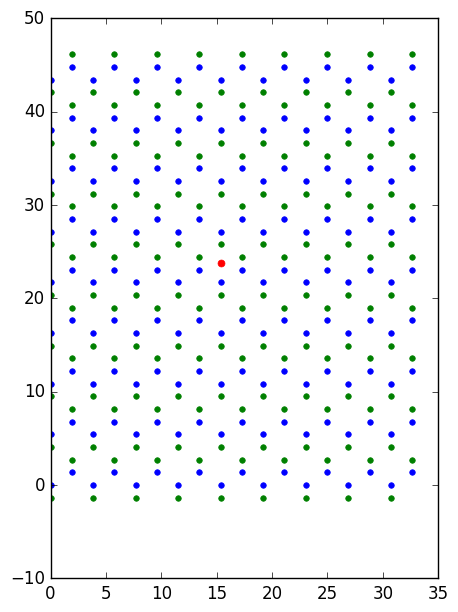

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3278b5cd0>

In [23]:
at, b, x0 = si_plane(9)
figure(figsize=(5,7))
plot_layers(at, x0)


In [24]:
# decay of forces without equilibrating the shifts
at, _, _ = si_plane(9)
calc = sw_eq()
x0 = JVecF([-2.0, -2.0, 0.0])
u = x -> 0.4 * [(x-x0)[1:2]/norm((x-x0)[1:2]); 0.0]
X = [ x + u(x) for x in positions(at) ]
set_positions!(at, X)
f = norm.(forces(calc, at))
r = dists(at, x0)
loglog(r, f, "r.", markersize=2)
loglog(r, 10*r.^(-2), "g.", r, 10*r.^(-1), "b.", markersize=1)


LoadError: invalid redefinition of constant f

In [25]:

function DpWcb(F, p, at = bulk("Si", pbc=true), sw = sw_eq())
    set_defm!(at, F)
    X = positions(at)
    X[2] = X[1] + p
    set_positions!(at, X)
    return -forces(sw, at)[2]
end


function DpDpWcb()
    at = bulk("Si", pbc=true)
    sw = sw_eq()
    F0 = defm(at)
    p0 = positions(at)[2] |> Vector
    h = 1e-5
    DpDpW = zeros(3, 3)
    for i = 1:3 
        p0[i] += h 
        DpW1 = DpWcb(F0, JVecF(p0), at, sw)
        p0[i] -= 2*h 
        DpW2 = DpWcb(F0, JVecF(p0), at, sw)
        p0[i] += h
        DpDpW[:, i] = (DpW1 - DpW2) / (2*h)
    end 
    return 0.5 * (DpDpW + DpDpW')
end


type WcbQuad
    DpDpW::Matrix{Float64}
    DpDpW_inv::Matrix{Float64}
    at::AbstractAtoms
    sw::StillingerWeber
end

function WcbQuad()
    DpDpW = DpDpWcb()
    return WcbQuad(DpDpW, pinv(DpDpW), bulk("Si", pbc=true), sw_eq())
end 

function (W::WcbQuad)(F)
    p0 = positions(W.at)[2]
    p1 = p0 - W.DpDpW_inv * DpWcb(F, p0, W.at, W.sw)
    p2 = p1 - W.DpDpW_inv * DpWcb(F, p1, W.at, W.sw)
    return p2
end

# # this is probably a test of WcbQuad, which I don't remember at all 

# at = bulk("Si", cubic=false, pbc = true)
# sw = sw_eq()
# @show maxnorm(forces(sw, at))
# F = defm(at)
# G = rand(JMatF)
# for p = 2:6
#     h = 0.1^p 
#     set_defm!(at, F + h * G, updatepositions=true)
#     @show maxnorm(forces(sw, at))
# end 
#     ;
# # this is probably another test of WcbQuad, which I don't remember at all 

# at = bulk("Si", cubic=false, pbc = true)
# sw = sw_eq()
# @show maxnorm(forces(sw, at))
# F0 = defm(at)
# G = rand(JMatF)
# W = WcbQuad()
# for q = 2:6
#     h = 0.1^q
#     F = F0 + h * G
#     ph = W(F)
#     @show ph
#     set_defm!(at, F, updatepositions=false)
#     X = positions(at)
#     X[2] = ph 
#     set_positions!(at, X)
#     @show maxnorm(forces(sw, at))
# end 
# ;
;

In [26]:
# we now want to take the following example but apply 
# the minimised shifts

# at, _, _ = si_plane(9)
# calc = sw_eq()
# x0 = JVecF([-2.0, -2.0, 0.0])
# X = [ x + 0.4 * [((x-x0)/norm(x-x0))[1:2]; 0.0] for x in positions(at)]
# set_positions!(at, X)

"""
a function that identifies multi-lattice structure in 2 layers of bulk-Si
(yes - very restrictive but will do for now!)
"""
function si_multilattice(at)
    J0 = Int[] 
    J1 = Int[]
    Jdel = Int[]
    for (i, j, r, R, _) in sites(at, rnn("Si")+0.1)
        foundneig = false 
        for (jj, RR) in zip(j, R)
            if (RR[1] == 0.0) && (abs(RR[2] - 1.3575) < 1e-3)      
                # neighbour above >> make (i, jj) a site
                push!(J0, i)
                push!(J1, jj)
                foundneig = true
                break
            elseif (RR[1] == 0.0) && (abs(RR[2] + 1.3575) < 1e-3)  
                # neighbour below >> (jj, i) is a site that will be pushed when i ↔ jj
                foundneig = true
                break
            end
        end
        if !foundneig
            # i has no neighbour above or below >> probably we just get rid of it
            push!(Jdel, i)
        end
    end
    return J0, J1, Jdel 
end 

# # testing si_multilattice

# at, _, _ = MaterialsScienceTools.Dislocations_Silicon_hard_110.fcc_edge_plane("Si")
# at = at * (7, 3, 1)
# I0, I1, Idel = si_multilattice(at)
# X = positions(at) |> mat 

# figure(figsize=(5,3))
# plot_layers(at)
# plot(X[1,I0], X[2,I0],"m+")
# plot(X[1,I1], X[2,I1],"c+")
# plot(X[1,Idel], X[3,Idel], "yx")





function symml_displacement!(at, u)
    I0, I1, Idel = si_multilattice(at)
    @assert isempty(Idel)  # if Idel is not empty then (for now) we don't know what to do 
    X = positions(at)
    W = WcbQuad()
    F0 = defm(W.at)
    p0 = W(F0)
    # transformation matrices
    Tp = [0 1/√2  -1/√2; 1 0 0; 0 1/√2 1/√2]
    Tm = diagm([1,1,-1]) * Tp
    
    for (i0, i1) in zip(I0, I1)   # each pair (i0, i1) corresponds to a ML lattice site
        x0, x1 = X[i0], X[i1]
        x1[3] > x0[3] ? T = Tp : T = Tm
        x̄ = 0.5 * (x0 + x1)   # centre of mass of the bond
        U, ∇U = u(x̄)          # displacement and displacement gradient
        F = T' * (I + ∇U) * T
        q = T * (W(F * F0) - p0)    # construct the shift corresponding to F = Id + ∇U
        X[i0], X[i1] = x0 + U - 0.5 * q, x1 + U + 0.5 * q
    end 
    set_positions!(at, X)
    return at 
end 

function ml_displacement!(at, u)
    I0, I1, Idel = si_multilattice(at)
    @assert isempty(Idel)  # if Idel is not empty then (for now) we don't know what to do 
    X = positions(at)
    W = WcbQuad()
    
    # transformation matrices
    Tp = [0 1/√2  -1/√2; 1 0 0; 0 1/√2 1/√2]
    Tm = diagm([1,1,-1]) * Tp

    F0 = defm(W.at)  # get reference information
    p0 = W(F0)
    
    for (i0, i1) in zip(I0, I1)   # each pair (i0, i1) corresponds to a ML lattice site
        x0, x1 = X[i0], X[i1]
        x1[3] > x0[3] ? T = Tp : T = Tm
        U, ∇U = u(x0)            # displacement and displacement gradient
        F = T' * (I + ∇U) * T
        q = T * (W(F * F0) - p0)   # construct the shift corresponding to F = Id + ∇U
        X[i0], X[i1] = x0 + U, x1 + U + q
    end 
    set_positions!(at, X)
    return at 
end 



ml_displacement! (generic function with 1 method)

In [27]:

x0 = JVecF([-2.0, -2.0, 0.0])
u = x -> 0.4 * [(x-x0)[1:2]/norm((x-x0)[1:2]); 0.0]
# u = x -> zeros(3)
∇u = x -> ForwardDiff.jacobian(u, x)

calc = sw_eq()
at, _, _ = si_plane(15)
ml_displacement!(at, x -> (u(x), ∇u(x)))
f = forces(calc, at)
at, _, _ = si_plane(15)
symml_displacement!(at, x -> (u(x), ∇u(x)))
fsym = forces(calc, at)

r0 = rnn("Si")
X = positions(at) |> mat 
x, y = X[1,:], X[2,:]
xL, xR = extrema(x); yL, yR = extrema(y)
Iint = find( (xL+2*r0 .< x .< xR - 2*r0) .* (yL+2*r0 .< y .< yR - 2*r0) )


figure()
subplot(1,2,1)
plot_layers(at)
subplot(1,2,2)
f = norm.(f)[Iint]
fsym = norm.(fsym)[Iint]
r = dists(at, x0)[Iint]
loglog(r, f, "r.", r, fsym, "m.", markersize=2)
loglog(r, 50*r.^(-2), "g.", r, 10*r.^(-1), "b.", markersize=1)
legend(("wo sym", "with sym", "r^{-2}", "r^{-1}"))


LoadError: invalid redefinition of constant f

In [39]:
# * `u_edge{T}(x, y, b, C::Array{T,N}) -> ux, uy`
# * `C` can be either 3 x 3 x 3 x 3 (`elastic_moduli`) or 6 x 6 (`voigt_moduli`)
# This function computes the anisotropic CLE solution for an in-plane
# edge dislocation. The elastic moduli are taken to within `TOL` accuracy (
#    this is a keyword argument)
# """

module Edge

import MaterialsScienceTools, ForwardDiff

type EdgeCubic{T1,T2,T3,T4}
    A::Matrix{T1}
    D::Vector{T2}
    p::Vector{T3}
    x0::T4
end 

function EdgeCubic{T}(b::Real, Cv::Array{T,2}, a::Real)
    # clean up the tensor
   test1 = Cv[1,1]
   test2 = Cv[1,2]
   test3 = Cv[6,6]
   Cv = zeros(6,6)
   Cv[1,1] = test1
   Cv[1,2] = test2
   Cv[6,6] = test3
   #Zero out elasticity tensor from any numerical artifacts
   Cv[2,2] = Cv[3,3] = Cv[1,1]
   Cv[1,3] = Cv[2,3] = Cv[2,1] = Cv[3,1] = Cv[3,2] = Cv[1,2]
   Cv[4,4] = Cv[5,5] = Cv[6,6]

   # parameters needed for the Hirth/Lothe solution
   bar = sqrt( .5*Cv[1,1]*(Cv[1,1] +Cv[1,2] + 2.0*Cv[4,4]) )
   C = ( (bar + Cv[1,2])*(bar - Cv[1,2] - 2.0*Cv[4,4] )  )/(bar*Cv[4,4])
   lem = (bar/Cv[1,1])^(1/2)
   delta2 = sqrt(-C)
   delta1 = sqrt(Complex(C+4))
    
   # Now compute using Hirth and Lothe which should be valid for 110 dislocation
   # This should use K instead of Cv
   # Something seems to be either wrong with these formulas or numeric issues are arising
   # Skip to general formula using complex logs
   K = MaterialsScienceTools.Elasticity_110.fourth_order_basis(Cv,a)
   Cvoigt = round(K, 3)

   # more parameters
   c̄11 = sqrt(K[1,1]*K[2,2])    # (13-106)
   lam = (K[1,1]/K[2,2])^(1/4)
   ϕ = 0.5 * acos( (K[1,2]^2 + 2*K[1,2]*K[6,6] - c̄11^2) / (2.0*c̄11*K[6,6]) )
   apple = - lam*(K[6,6]*exp(im*ϕ) + c̄11*exp(-im*ϕ))/(K[1,2]+K[6,6])
   dodo = im*b[1,1]/(2.0*c̄11*sin(2*ϕ))*(K[1,2] - c̄11*exp(2*im*ϕ))

   #Should test this against solving the full linear system
   A = Complex{Float64}[0 1 1; 0 apple -apple; 0 0 0]
   #Set up for burgers vector in x1 direction only
   D = zeros(6,1)
   D = [ 0; 0; real(dodo); imag(dodo); -real(dodo); -imag(dodo)]
   p = MaterialsScienceTools.Elasticity_110.sextic_roots(K)
   #Do some funny business with root switching here.  This could be what is screwing things up.
   #May have to change the roots elsewhere instead
   p[3,1] = -p[2,1]
    
   return EdgeCubic(A, D, p, zeros(2))
end

function evaluate(U::EdgeCubic, X::AbstractVector)
    x = X[1] - U.x0[1]
    y = X[2] - U.x0[2]
    A, D, p = U.A, U.D, U.p
   ux = real( im/(2*π)*(A[1,2]*(D[3] + D[4]*im)*log(x+p[2]*y) + A[1,3]*(D[5] + D[6]*im)*log(x+p[3]*y)   ))
   uy = real( im/(2*π)*(A[2,2]*(D[3] + D[4]*im)*log(x+p[2]*y) + A[2,3]*(D[5] + D[6]*im)*log(x+p[3]*y)   ))
   return [ux, uy, 0.0]
end

function jacobian(U::EdgeCubic, X::AbstractVector) 
    x = X[1] - U.x0[1]
    y = X[2] - U.x0[2]
    A, D, p = U.A, U.D, U.p
    uxx = real( im/(2*π)*(A[1,2]*(D[3] + D[4]*im)/(x+p[2]*y) + A[1,3]*(D[5] + D[6]*im)/(x+p[3]*y) ) )
    uxy = real( im/(2*π)*(A[1,2]*(D[3] + D[4]*im)*p[2]/(x+p[2]*y) + A[1,3]*(D[5] + D[6]*im)*p[3]/(x+p[3]*y) ) )
    uyx = real( im/(2*π)*(A[2,2]*(D[3] + D[4]*im)/(x+p[2]*y) + A[2,3]*(D[5] + D[6]*im)/(x+p[3]*y)   ))
    uyy = real( im/(2*π)*(A[2,2]*(D[3] + D[4]*im)*p[2]/(x+p[2]*y) + A[2,3]*(D[5] + D[6]*im)*p[3]/(x+p[3]*y)   ))    
    return [uxx uxy 0.0; uyx uyy 0.0; 0.0 0.0 0.0]
end

function (U::EdgeCubic)(X::AbstractVector)
    return evaluate(U, X), jacobian(U, X)
end

# x0 = rand(2)
# u, ∂u = U(x0)
# for p  = 3:10
#     h = 0.1^p
#     gh = zeros(2,2)
#     for i = 1:2
#         x0[i] += h
#         uh, _ = U(x0)
#         gh[:,i] = (uh - u) / h
#         x0[i] -= h 
#     end 
#     println("p = $p: err = ", vecnorm(∂u - gh, Inf))
# end 

end 





Edge

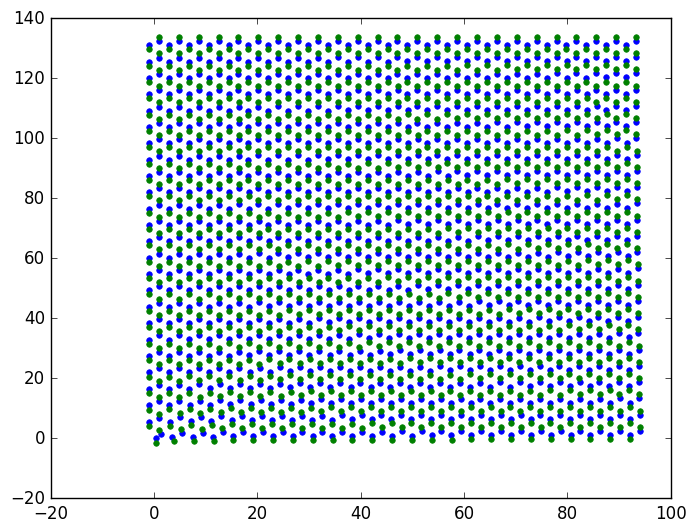

In [40]:
reload("MaterialsScienceTools")

# DisAl = MaterialsScienceTools.Dislocations_Al_hard_110
# at, xcore = DisAl.fcc_edge_geom("Al", 21.1, truncate=false, cle=:anisotropic, calc = calc,zDir=1)


# U = Edge.EdgeCubic()

# setup undeformed geometry
at, b, _ = si_plane(25)
a = cell(bulk("Si", cubic=true))[1,1]  # = 5.43

# get elastic constants
sw = sw_eq()
atu = bulk("Si", pbc=true)
set_calculator!(atu, sw)
Cv = MaterialsScienceTools.Elasticity.voigt_moduli(atu)  # TODO: fix the elastic moduli!!!
Cv = round(Cv, 8)

# edge solution 
U = Edge.EdgeCubic(b, Cv, a)
U.x0 = [-1.0, -1.0]
ml_displacement!(at, U)

f = forces(calc, at)
# at, _, _ = si_plane(15)
# symml_displacement!(at, x -> (u(x), ∇u(x)))
# fsym = forces(calc, at)


plot_layers(at)

In [ ]:
# function ulin_edge_isotropic(X, b, ν)
#     x, y = X[1,:], X[2,:]
#     r² = x.^2 + y.^2
#     ux = b/(2*π) * ( angle(x + im*y) + (x .* y) ./ (2*(1-ν) * r²) )
#     uy = -b/(2*π) * ( (1-2*ν)/(4*(1-ν)) * log(r²) + - 2 * y.^2 ./ (4*(1-ν) * r²) )
#     return [ux'; uy']
# end

# function si_edge(R) 
#     at, b, xcore = si_plane(R)
#     X = positions(at) |> mat
#     X2d = X[1:2,:] .- xcore[1:2]
#     U = ulin_edge_isotropic(X2d, b, 0.25)
#     X[1:2, :] += U
#     set_positions!(at, vecs(X))
#     return at, JVecF(xcore)
# end 

# at, x0 = si_edge(31)
# calc = sw_eq()
# f = norm.(forces(calc, at))
# r = dists(at, x0)
# loglog(r, f, "r.", markersize=2)
# loglog(r, 10*r.^(-2), "g.", r, 10*r.^(-1), "b.", markersize=1)

function si_edge_outside(R) 
    at, b, xcore = si_plane(R)
    X = positions(at) |> mat
    X2d = X[1:2,:] .+ [2.0, 2.0]
    U = ulin_edge_isotropic(X2d, b, 0.25)
    X[1:2, :] += U
    set_positions!(at, vecs(X))
    return at, JVecF([2.0, 2.0, 0.0])
end 

at, x0 = si_edge_outside(13) 
f = norm.(forces(calc, at))
r = dists(at, x0)
loglog(r, f, "r.", markersize=2)
loglog(r, 10*r.^(-2), "g.", r, 10*r.^(-1), "b.", markersize=1)